<a href="https://colab.research.google.com/github/BaakisanB/Python/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Freelancing/Electricity_Consumption_2023-04-06_18-28-08.csv')

In [ ]:
df

,billing_portion,community,rate_category,consumption_period,calendar_month,contract_account,business_partner,consumption_unit
0,912,393,COMMELEC,08.03.2023,202303,3007759777,10020574,100.0
1,B32,393,COMMELEC,15.03.2023,202303,3007749701,10045044,100.0
2,B34,591,RESIEXPE,22.03.2023,202303,3007698761,17069820,4879.0
3,B20,332,RESIEXPE,05.03.2023,202303,3007671909,10358459,33240.0
4,931,618,GOVTELEC,07.03.2023,202303,3007652891,10138030,27520.0
...,...,...,...,...,...,...,...,...
985527,B18,318,RESIEXPE,04.03.2023,202303,2000700870,10352498,603.0
985528,B18,318,COMMELEC,04.03.2023,202303,2000647715,10376569,439.0
985529,D21,127,RESIEXPE,06.03.2023,202303,2000490441,10466813,4199.0
985530,B18,318,RESIEXPE,04.03.2023,202303,2000285333,10454393,103.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985532 entries, 0 to 985531
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   billing_portion     985527 non-null  object 
 1   community           985532 non-null  int64  
 2   rate_category       985532 non-null  object 
 3   consumption_period  985532 non-null  object 
 4   calendar_month      985532 non-null  int64  
 5   contract_account    985532 non-null  int64  
 6   business_partner    985532 non-null  int64  
 7   consumption_unit    985532 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 60.2+ MB


In [ ]:
df.describe()

,community,calendar_month,contract_account,business_partner,consumption_unit
count,985532.000000,985532.000000,9.855320e+05,9.855320e+05,9.855320e+05
mean,433.094738,202302.998001,2.114186e+09,1.150944e+07,2.811104e+03
std,193.919324,0.691679,2.687358e+08,1.568501e+06,2.956944e+04
min,101.000000,201806.000000,2.000000e+09,1.000000e+07,1.000000e+00
25%,318.000000,202303.000000,2.030273e+09,1.069468e+07,2.010000e+02
50%,383.000000,202303.000000,2.038613e+09,1.132511e+07,4.110000e+02
75%,621.000000,202303.000000,2.042914e+09,1.171646e+07,9.990700e+02
max,991.000000,202303.000000,3.007760e+09,2.000002e+08,8.868000e+06


In [ ]:
df.dropna(inplace=True)


In [ ]:
label_encoder = LabelEncoder()


In [ ]:
df['billing_portion'] = label_encoder.fit_transform(df['billing_portion'])


In [ ]:
df['rate_category'] = label_encoder.fit_transform(df['rate_category'])


In [ ]:
# Feature Engineering (Extracting relevant information from datetime)
df['consumption_period'] = pd.to_datetime(df['consumption_period'], format='%d.%m.%Y')
df['month'] = df['consumption_period'].dt.month
df['year'] = df['consumption_period'].dt.year

In [ ]:
# Dropping unnecessary columns
df.drop(['consumption_period', 'calendar_month'], axis=1, inplace=True)

In [ ]:
# Standardizing Numerical Features
numerical_features = ['community', 'contract_account', 'business_partner', 'consumption_unit']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

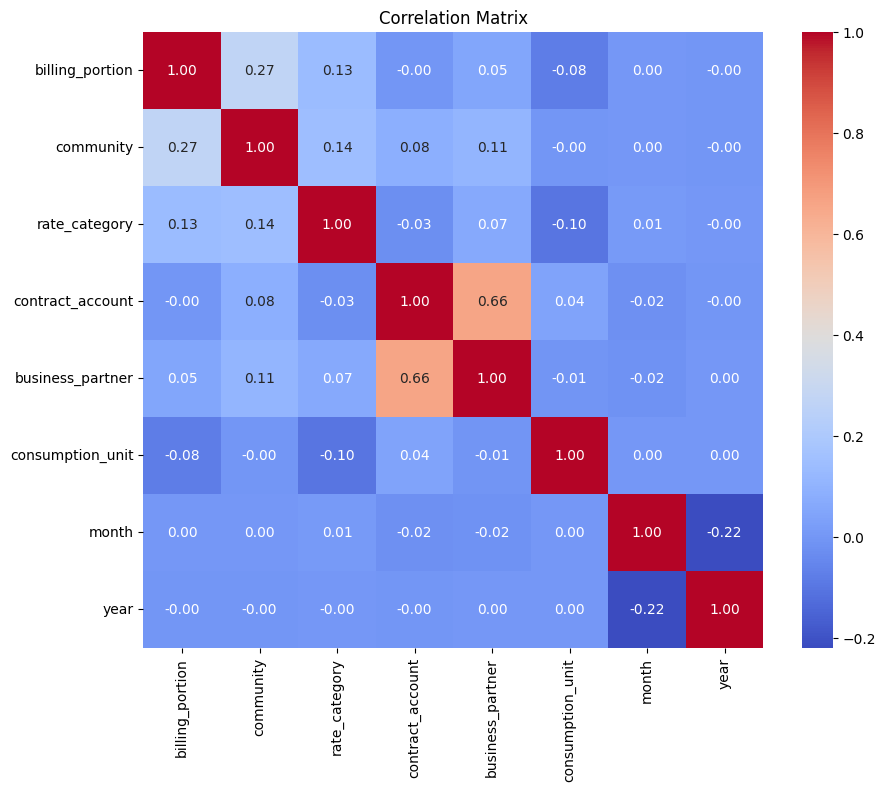

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

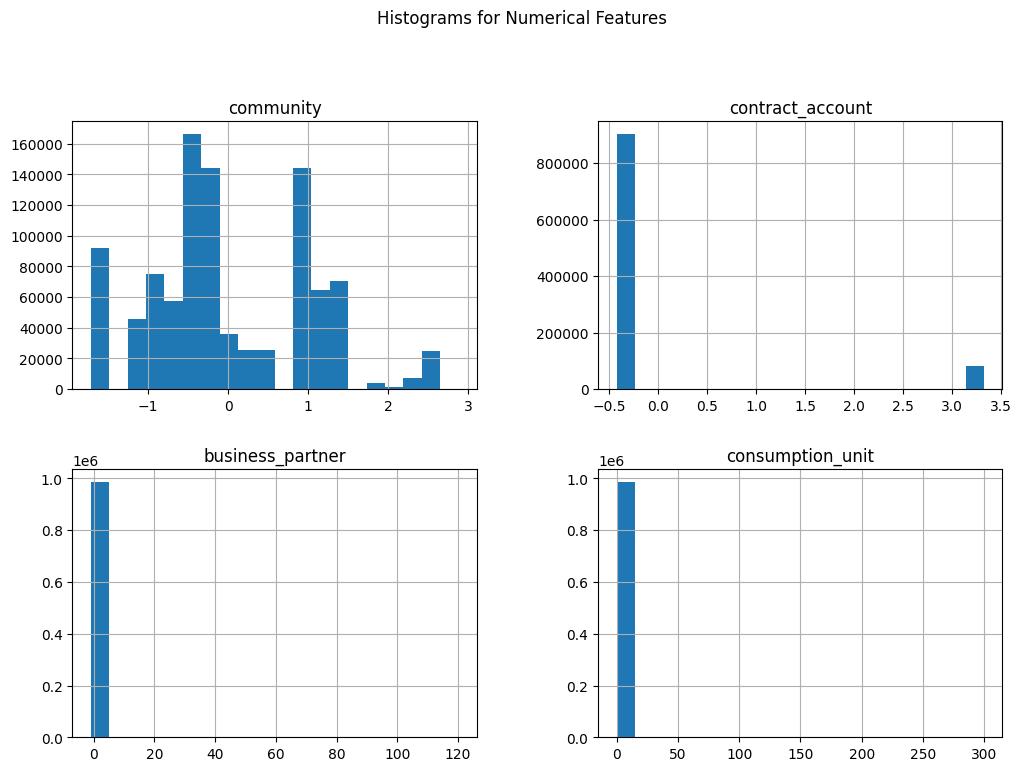

In [ ]:
# Visualize histograms for numerical features
numerical_features = ['community', 'contract_account', 'business_partner', 'consumption_unit']
df[numerical_features].hist(figsize=(12, 8), bins=20)
plt.suptitle("Histograms for Numerical Features", y=1.02)
plt.show()

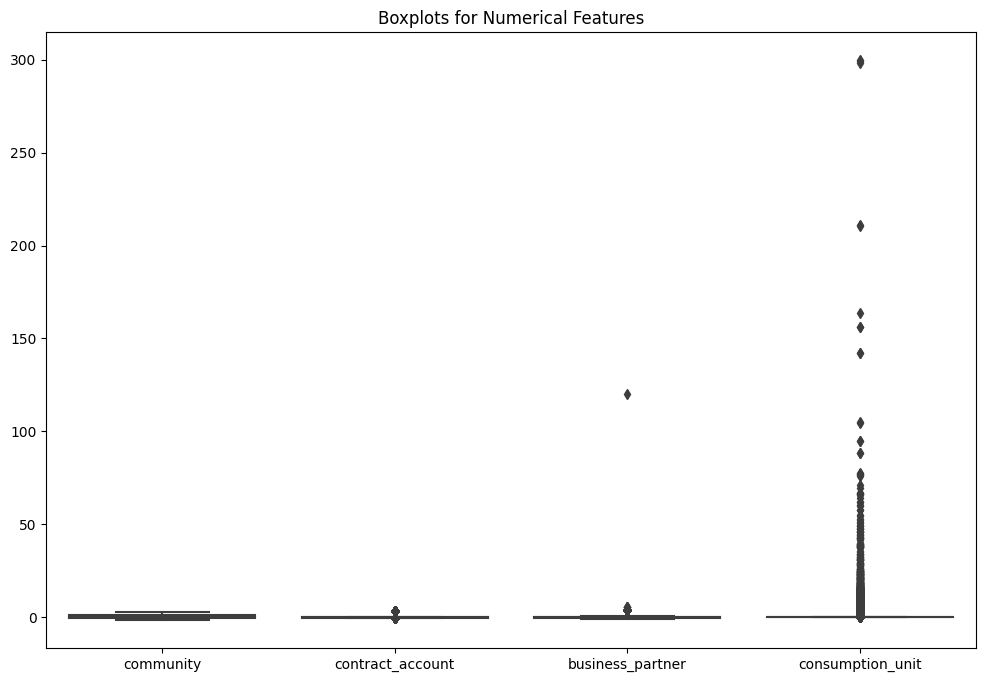

In [ ]:
# Visualize boxplots for numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_features])
plt.title("Boxplots for Numerical Features")
plt.show()

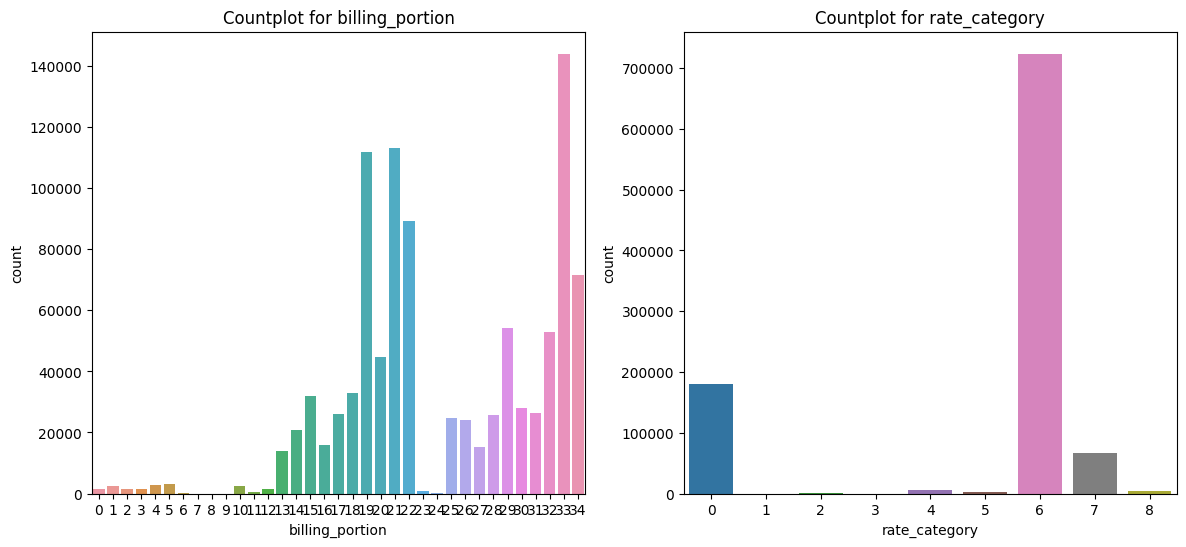

In [ ]:
# Visualize countplots for categorical features
categorical_features = ['billing_portion', 'rate_category']
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(14, 6))
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f"Countplot for {feature}")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Split the data into features (X) and target variable (y)
X = df[['community', 'contract_account', 'business_partner', 'consumption_unit', 'month', 'year']]
y = df['consumption_unit']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Reshape the data for LSTM input (assuming univariate time series)
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

RuntimeError: ignored

In [ ]:
# Convert 'consumption_period' to datetime for time series analysis
df['consumption_period'] = pd.to_datetime(df['consumption_period'], format='%d.%m.%Y')

KeyError: ignored

In [ ]:
df.dropna(inplace=True)


In [ ]:
label_encoder = LabelEncoder()


In [ ]:
df['billing_portion'] = label_encoder.fit_transform(df['billing_portion'])
df['rate_category'] = label_encoder.fit_transform(df['rate_category'])

In [ ]:
df['month'] = df['consumption_period'].dt.month
df['year'] = df['consumption_period'].dt.year

In [ ]:
df.drop(['consumption_period', 'calendar_month'], axis=1, inplace=True)


In [ ]:
numerical_features = ['community', 'contract_account', 'business_partner', 'consumption_unit']


In [ ]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [ ]:
prophet_df = df[['consumption_period', 'consumption_unit']].rename(columns={'consumption_period': 'ds', 'consumption_unit': 'y'})


KeyError: ignored

In [ ]:
print(df.head())


   billing_portion  community  rate_category  contract_account  \
0                1  -0.206759              0          3.325117   
1               21  -0.206759              0          3.325079   
2               22   0.814284              6          3.324890   
3               15  -0.521323              6          3.324790   
4               10   0.953517              4          3.324719   

   business_partner  consumption_unit  month  year  
0         -0.949229         -0.091684      3  2023  
1         -0.933628         -0.091684      3  2023  
2          3.545026          0.069936      3  2023  
3         -0.733810          1.029069      3  2023  
4         -0.874345          0.835626      3  2023  


In [ ]:
print(prophet_df.head())


NameError: ignored

In [ ]:
# Sorting the data by date
df.sort_values('consumption_period', inplace=True)

# Visualization of Electricity Consumption over Time
plt.figure(figsize=(12, 6))
plt.plot(df['consumption_period'], df['consumption_unit'], label='Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (Unit)')
plt.title('Electricity Consumption Over Time')
plt.legend()
plt.show()

KeyError: ignored

In [ ]:
# # Distribution of Electricity Consumption
# plt.figure(figsize=(8, 6))
# sns.histplot(data['consumption_unit'], kde=False)
# plt.title('Distribution of Electricity Consumption')
# plt.xlabel('Consumption (Unit)')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
df = df.drop('calendar_month', axis = 1)

KeyError: ignored

In [ ]:
df.head()

,billing_portion,community,rate_category,contract_account,business_partner,consumption_unit,month,year
0,1,-0.206759,0,3.325117,-0.949229,-0.091684,3,2023
1,21,-0.206759,0,3.325079,-0.933628,-0.091684,3,2023
2,22,0.814284,6,3.324890,3.545026,0.069936,3,2023
3,15,-0.521323,6,3.324790,-0.733810,1.029069,3,2023
4,10,0.953517,4,3.324719,-0.874345,0.835626,3,2023


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsoluteError

# Drop rows with missing values
df = df.dropna()

# Encode categorical columns
label_encoders = {}
for column in ['billing_portion', 'rate_category', 'consumption_period']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

df

KeyError: ignored

In [ ]:
# Extract features and target variable
X = df.drop(columns=['consumption_unit'])  # Features
y = df['consumption_unit']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Create the LSTM neural network
model = Sequential()
model.add(LSTM(128, activation="relu", input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(1))

# Compile the model with Mean Absolute Error as a metric
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[MeanAbsoluteError()])

model.summary()

NameError: ignored

In [ ]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=2)

# Evaluate the model's performance
loss, mae = model.evaluate(X_test_reshaped, y_test, verbose=0)

print("Mean Squared Error:", loss)
print("Mean Absolute Error:", mae)


Epoch 1/100
24639/24639 - 135s - loss: 1.0451 - mean_absolute_error: 0.1222 - 135s/epoch - 5ms/step
Epoch 2/100
24639/24639 - 135s - loss: 1.0395 - mean_absolute_error: 0.1235 - 135s/epoch - 5ms/step
Epoch 3/100
24639/24639 - 129s - loss: 1.0710 - mean_absolute_error: 0.1254 - 129s/epoch - 5ms/step
Epoch 4/100
24639/24639 - 126s - loss: 1.0451 - mean_absolute_error: 0.1253 - 126s/epoch - 5ms/step
Epoch 5/100
24639/24639 - 125s - loss: 1.0433 - mean_absolute_error: 0.1262 - 125s/epoch - 5ms/step
Epoch 6/100
24639/24639 - 124s - loss: 1.2649 - mean_absolute_error: 0.1254 - 124s/epoch - 5ms/step
Epoch 7/100


In [ ]:
! pip install prophet

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from prophet import Prophet

# Drop rows with missing values
data = data.dropna()

# Convert 'consumption_period' to datetime
data['consumption_period'] = pd.to_datetime(data['consumption_period'])

# Rename columns for Prophet
data.rename(columns={'consumption_period': 'ds', 'consumption_unit': 'y'}, inplace=True)

# Extract features and target variable
X = data.drop(columns=['y'])  # Features
y = data['y']  # Target variable

# Sort data chronologically
data = data.sort_values('ds')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the training data for Prophet
train_data = pd.concat([X_train, y_train], axis=1)

# Create the Prophet model
model = Prophet()

In [ ]:
model.fit(train_data)

# Make predictions for the test set
future = model.make_future_dataframe(periods=1000)
forecast = model.predict(future)

# Extract predicted values for the test set
predictions = forecast['yhat'][len(train_data):]

# Evaluate the model's performance
mse = np.mean((predictions - y_test.values)**2)
mae = np.mean(np.abs(predictions - y_test.values))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

In [ ]:
# # Check the data for missing values or gaps
# data = data.dropna()

# # Check the data for outliers
# outliers = data[np.abs(data - data.mean()) > 3 * data.std()]
# data = data.drop(outliers.index)

# # Scale the data
# data = data / data.max()

In [ ]:
# # Split the data into training and test sets
# train_data = data[:int(0.8 * len(data))]
# test_data = data[int(0.8 * len(data)):]

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA

# # Identify the trend and seasonal components of the data set
# trend = seasonal_decomp(data["y"], freq=7).trend
# seasonal = seasonal_decomp(data["y"], freq=7).seasonal
# residual = data["y"] - trend - seasonal

# # Calculate the properties of the ARIMA model
# p = 1
# d = 1
# q = 1

# # Create the ARIMA model
# model = ARIMA(residual, order=(p, d, q))

In [ ]:
# # Train the model using the training data set
# model.fit()

In [ ]:
# # Make predictions on the test data set
# predictions = model.predict(start=len(train_data), end=len(data))

# # Compare the predictions to the actual values and calculate the accuracy
# accuracy = np.mean(predictions == test_data["y"])

In [ ]:
# # Split the data into training and test sets
# train_data = data[:int(0.8 * len(data))]
# test_data = data[int(0.8 * len(data)):]

# # Create the LSTM neural network
# model = Sequential()
# model.add(LSTM(128, activation="relu", input_shape=(train_data.shape[1],)))
# model.add(Dense(1))

# # Train the model with the MSE loss function
# model.compile(loss="mse", optimizer="adam")
# model.fit(train_data, train_data[:, 0], epochs=100)

# # Evaluate the model's performance
# predictions = model.predict(test_data)

# # Calculate the MSE loss
# mse = np.mean((predictions - test_data[:, 0])**2)

# print("MSE loss:", mse)

In [ ]:
# # Create the Prophet model
# model = Prophet()
# model.fit(data)

# # Train the model with the MSE loss function
# model.fit(data, loss="mse")

# # Evaluate the model's performance
# future = model.make_future_dataframe(periods=100)
# forecast = model.predict(future)

# # Calculate the MSE loss
# mse = np.mean((forecast["yhat"] - data["y"])**2)

# print("MSE loss:", mse)

In [ ]:
# # Check the data for missing values or gaps
# data = data.dropna()

# # Check the data for outliers
# outliers = data[np.abs(data - data.mean()) > 3 * data.std()]
# data = data.drop(outliers.index)

# # Scale the data
# data = data / data.max()

In [ ]:
# Check the data for missing values or gaps
# data = data.dropna()

# Check the data for outliers
# outliers = data[np.abs(data - data.mean()) > 3 * data.std()]

# Determine the cause of the outliers
# for outlier in outliers:
#     print(outlier, data[outlier])

In [ ]:
# # Replace outliers with the mean
# for outlier in outliers:
#     data[outlier] = data.mean()

In [ ]:
# # Delete outliers
# data = data.drop(outliers.index)